# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

First, let's extract training images and labels. We note that $train["X"]$ as shape $(32, 32, 3, 73257)$ which is not convinient.
So we will use the numpy $transpose$ method to swap axes so that the number of samples come the first at the index


In [41]:
X_train = train["X"].transpose(-1, 0,1,2)
y_train = train["y"]
X_train.shape

(73257, 32, 32, 3)

Then we do the same for the test dataset

In [42]:
X_test = test["X"].transpose(-1, 0,1,2)
y_test = test["y"]
X_test.shape

(26032, 32, 32, 3)

Randomly selecting _n_im_ images and corresponding labels and display them

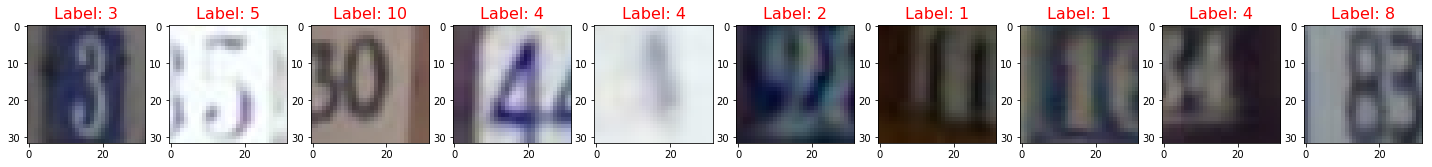

In [43]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

def random_display_nimg(img:np.ndarray, labels:np.ndarray, n_img:int, seed:int=100, gray_scale=False, ret_sample=False):
    """
    This function display n_img randomly selected and
    their corresponding labels 
    """
    np.random.seed(seed)
    samples = np.random.choice(np.arange(img.shape[0]), size=n_img)

    # create a figure and sho image within it
    fig, ax = plt.subplots(ncols=n_img, figsize=(25,20))
    if gray_scale:
        for i in range(n_img):
            ax[i].imshow(img[samples[i], :, :, 0])
            ax[i].set_title(f"Label: {labels[samples[i], 0]}", color="r", fontsize=16)
    else:
        for i in range(n_img):
            ax[i].imshow(img[samples[i]])
            ax[i].set_title(f"Label: {labels[samples[i], 0]}", color="r", fontsize=16)
    # return samples if condition verified
    if ret_sample:
        return samples

random_display_nimg(img=X_train, labels=y_train, n_img=10, seed=0)

We can see from the above image that images with $0$ are labeled $10$. Since in tensorflow, using softmax labels range between 0 and $n_{class}$ (the number of class). We will replace 10 by 0. Otherwise our model will return error during training

In [44]:
# for training targets
y_train = np.where(y_train == 10, 0, y_train)
# for test targets
y_test = np.where(y_test == 10, 0, y_test)
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Converting training and test images to grayscale

In [45]:
# for training images
X_train = X_train.mean(axis=-1, keepdims=True)
print(X_train.shape)
#for test images
X_test = X_test.mean(axis=-1, keepdims=True)

(73257, 32, 32, 1)


Displaying random selected grayscale images

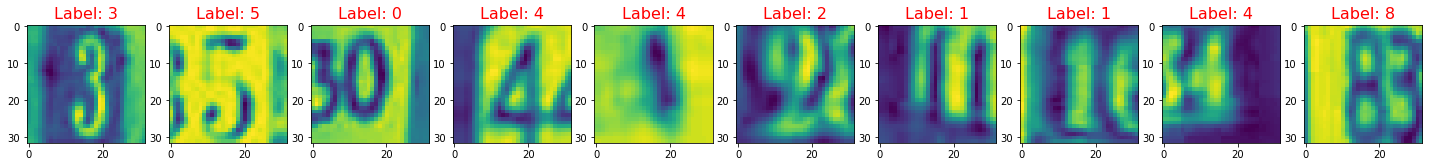

In [46]:
random_display_nimg(X_train, y_train, n_img=10, seed=0, gray_scale=True)

Let's normalized images before getting them to feed our ML NN

In [47]:
X_train /= 255.
X_test /= 255.

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

First, let's import important libraries and functions

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
!rm -r check_point_best_only/

designing the model

In [34]:
def get_mlp_model():
    model = Sequential([
        Flatten(input_shape=(32, 32, 1)),
        Dense(200, "relu", name="layer_1"),
        Dense(200, "relu", name="layer_2"),
        Dense(200, "relu", name="layer_3"),
        Dense(200, "relu", name="layer_4"),
        Dense(10, "softmax", name="layer_out")
    ])
    return model

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)              

Compile and train the model

In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Here I have chosen to use earlystopping and modelCheckpointCallback

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- This checkpoint save the weights that give the best accuracy on the validation set doing this operation at each epoch

In [15]:
checkpoint_path="check_point_best_only/checkpoint"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_freq="epoch",
                             save_weights_only=True, monitor="val_accuracy")

- this second checkpoint stop the running whenever the accuracy does not improve much one 3 iteration

In [16]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5)

In [17]:
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.09, callbacks=[checkpoint, early_stop], verbose=2)

Train on 66663 samples, validate on 6594 samples
Epoch 1/30
66663/66663 - 26s - loss: 1.9910 - accuracy: 0.2843 - val_loss: 1.6163 - val_accuracy: 0.4362
Epoch 2/30
66663/66663 - 24s - loss: 1.4201 - accuracy: 0.5196 - val_loss: 1.2724 - val_accuracy: 0.5713
Epoch 3/30
66663/66663 - 24s - loss: 1.1664 - accuracy: 0.6195 - val_loss: 1.1160 - val_accuracy: 0.6388
Epoch 4/30
66663/66663 - 24s - loss: 1.0684 - accuracy: 0.6572 - val_loss: 1.0320 - val_accuracy: 0.6691
Epoch 5/30
66663/66663 - 24s - loss: 0.9891 - accuracy: 0.6859 - val_loss: 0.9618 - val_accuracy: 0.6908
Epoch 6/30
66663/66663 - 24s - loss: 0.9377 - accuracy: 0.6998 - val_loss: 0.9812 - val_accuracy: 0.6762
Epoch 7/30
66663/66663 - 24s - loss: 0.8875 - accuracy: 0.7186 - val_loss: 0.9144 - val_accuracy: 0.7084
Epoch 8/30
66663/66663 - 23s - loss: 0.8575 - accuracy: 0.7291 - val_loss: 0.8448 - val_accuracy: 0.7329
Epoch 9/30
66663/66663 - 24s - loss: 0.8220 - accuracy: 0.7401 - val_loss: 0.8045 - val_accuracy: 0.7389
Epoch 

In [18]:
import pandas as pd

df = pd.DataFrame(history.history)

**Loss Vs epoch**

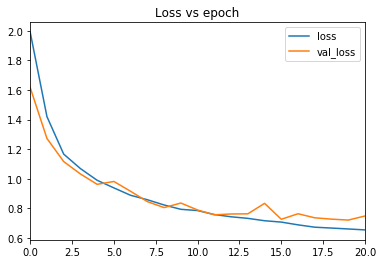

In [19]:
df.plot(y=["loss", "val_loss"], title="Loss vs epoch")

**Accuracy Vs epoch***

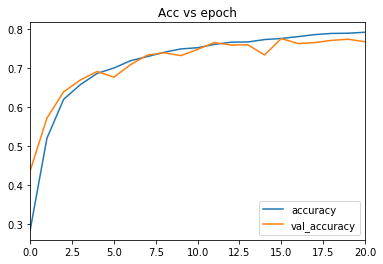

In [20]:
df.plot(y=["accuracy", "val_accuracy"], title="Acc vs epoch")

Accuracy and loss on the test set through evaluation method

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

26032/1 - 4s - loss: 0.7719 - accuracy: 0.7430


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

Let's import important function and modules

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout

Building the model

In [32]:
def get_cnn_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation="relu", padding="SAME", input_shape=(32,32,1)),
        BatchNormalization(),
        MaxPool2D(pool_size=3),
        Conv2D(16, kernel_size=3, activation="relu", padding="SAME"),
        BatchNormalization(),
        MaxPool2D(pool_size=3),
        #Dropout(0.5)
        Flatten(),
        Dense(128, "relu"),
        Dropout(0.5),
        Dense(128, "relu"),
        Dense(10, "softmax")
    ])
    return model

In [33]:
model = get_cnn_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)              

we can now compile the model

In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Callbacks

In [25]:
# save best weights only - checkpoint
checkpoint_path="check_point_best_only_CNN/checkpoint"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_freq="epoch",
                             save_weights_only=True, monitor="val_accuracy")
# early-stopping checkpoint
early_stop = EarlyStopping(monitor="val_accuracy", patience=5)

In [26]:
history_cnn = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.09, callbacks=[checkpoint, early_stop], verbose=2)

Train on 66663 samples, validate on 6594 samples
Epoch 1/30
66663/66663 - 368s - loss: 1.3065 - accuracy: 0.5617 - val_loss: 0.8268 - val_accuracy: 0.7323
Epoch 2/30
66663/66663 - 367s - loss: 0.7766 - accuracy: 0.7521 - val_loss: 0.6593 - val_accuracy: 0.7986
Epoch 3/30
66663/66663 - 368s - loss: 0.6643 - accuracy: 0.7905 - val_loss: 0.5850 - val_accuracy: 0.8094
Epoch 4/30
66663/66663 - 366s - loss: 0.6043 - accuracy: 0.8115 - val_loss: 0.4987 - val_accuracy: 0.8450
Epoch 5/30
66663/66663 - 367s - loss: 0.5715 - accuracy: 0.8229 - val_loss: 0.4676 - val_accuracy: 0.8534
Epoch 6/30
66663/66663 - 367s - loss: 0.5434 - accuracy: 0.8317 - val_loss: 0.4996 - val_accuracy: 0.8403
Epoch 7/30
66663/66663 - 366s - loss: 0.5171 - accuracy: 0.8395 - val_loss: 0.4534 - val_accuracy: 0.8602
Epoch 8/30
66663/66663 - 368s - loss: 0.5027 - accuracy: 0.8443 - val_loss: 0.4517 - val_accuracy: 0.8628
Epoch 9/30
66663/66663 - 368s - loss: 0.4893 - accuracy: 0.8477 - val_loss: 0.4472 - val_accuracy: 0.86

In [27]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

26032/1 - 45s - loss: 0.4331 - accuracy: 0.8542


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

Loss and accuracy on training set

In [37]:
# create MLP model with the same architecture as the model from which best weights were saved
model_mlp = get_mlp_model()

# create CNN model with the same architecture as the model from which best weights were saved
model_cnn = get_cnn_model()

Load best weights for MLP and CNN

In [39]:
# for MLP
model_mlp.load_weights("check_point_best_only/checkpoint")
# for CNN
model_cnn.load_weights("check_point_best_only_CNN/checkpoint")

In [87]:
def predictive__dist(predictions, title):
    """
    Bar plot of the predictive distribution
    Title: title of the figure
    """
    n_img = predictions.shape[0]
    x = np.arange(10)
    # create a figure and sho image within it
    fig, ax = plt.subplots(ncols=n_img, figsize=(25,6))
    
    for i in range(n_img):
        ax[i].bar(x, height=predictions[i])
        ax[i].set_xticks(x)
        ax[i].set_title(f"label: {np.argmax(predictions[i])}")
    fig.suptitle(title, fontsize=24)

Random select and display images from test set

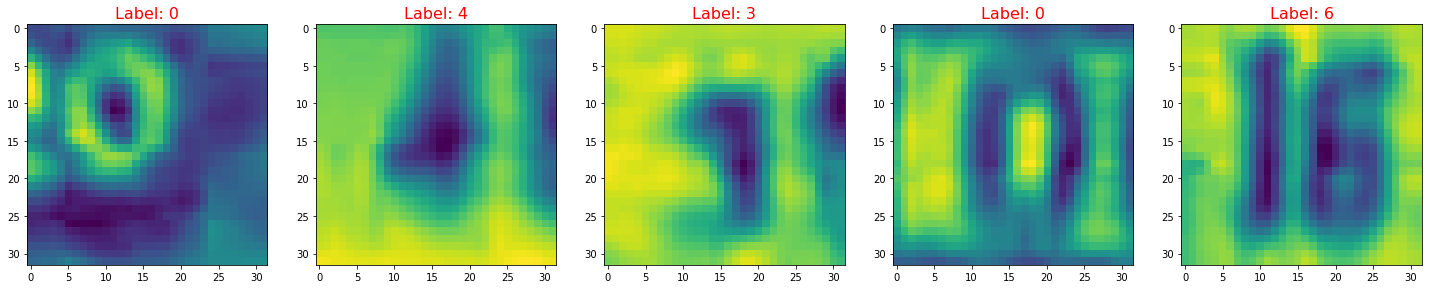

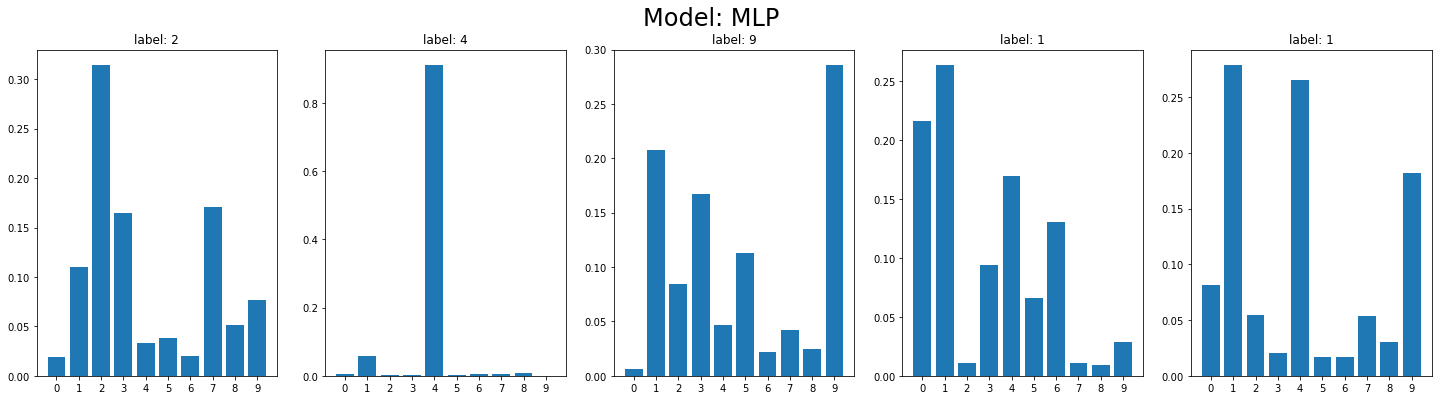

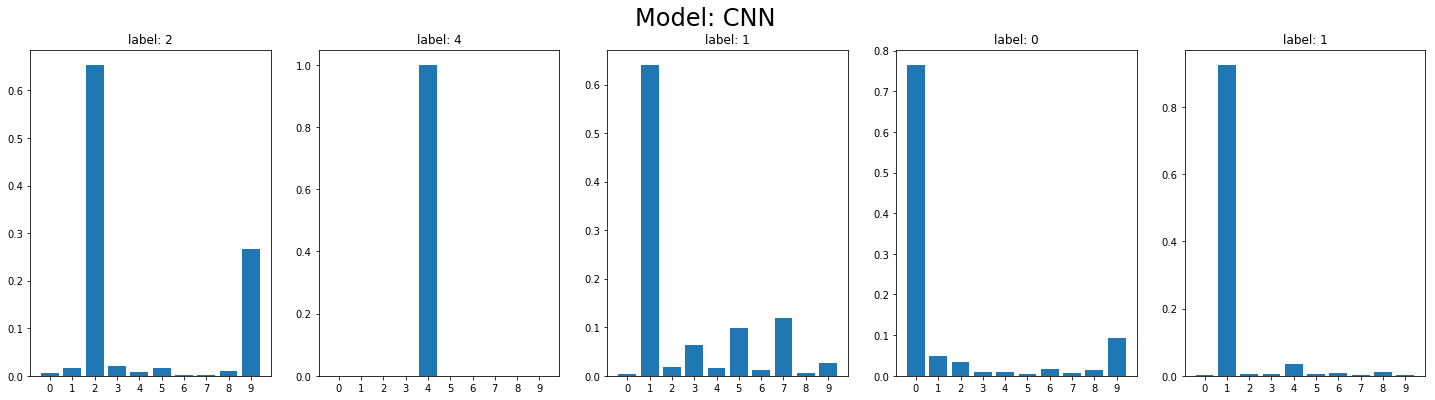

In [88]:
samples = random_display_nimg(X_test, y_test, n_img=5, seed=95, ret_sample=True, gray_scale=True)
pred_mlp = model_mlp.predict(X_test[samples], verbose=False)
pred_cnn = model_cnn.predict(X_test[samples], verbose=False)

predictive__dist(pred_mlp, title="Model: MLP")
predictive__dist(pred_cnn, title="Model: CNN")

CNN seems to be a better model, althought there are still margins to enhance this model which is still not perfect.
**Thank you !**